In [1]:
from pathlib import Path
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from cmath import phase
# from numpy.linalg import eig as eigenvectors
import pandas as pd
from datetime import date
import random
import matplotlib as mpl

from numpy.linalg import eigh as eigenvectors #compute real eigenvec and eigenvals (only for symmetric or Hermitian matrices)
from scipy.sparse.linalg import eigsh # BAD - but I don't know why
import networkx as nx

# PCA
from sklearn.decomposition import PCA
import pandas as pd

# UMAP
import umap

# K-MEANS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn
from sklearn.preprocessing import MinMaxScaler

# Stat test
from scipy.stats import ttest_ind, ttest_1samp, pearsonr

# Similaritys
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
import sklearn

# Normalization
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance

2023-08-29 19:43:52.371235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 19:43:52.523463: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-29 19:43:52.527162: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-29 19:43:52.527177: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
intr_nodes = [0,22,180,181,203,361,362,363,364,365,374,375,387,388]
intr_nodes_labels = ['L_V1','L_MT','L_SC','R_V1',
                     'R_MT','R_SC','L_LGN','L_Pulv',
                     'R_LGN','R_Pulv','L_Amy_lat',
                     'L_Amy_med','R_Amy_lat','R_Amy_med']

random_nodes_1 = [360,27,81,247,51,297,163,391,284,250,377,393,101,24]

In [3]:
# Get data path
cwd = Path(os.getcwd())
pardir = str(cwd.parent.absolute())
projdir = os.path.dirname(pardir)
projdir = os.path.dirname(projdir)
pardir, projdir

('/home/alessio/home/projects/Blindsight_LEIDA', '/home/alessio/home')

In [4]:
# Load subjects order
mypath=projdir+'/data/Blindsight_RestingState_Data/func_STD'
patients_list = []
with open(mypath+'/list_rest.txt') as f:
    lines = f.readlines()
    patients_paths = [line[:-1] for line in lines]

In [5]:
# Load Glasser
# Atlas
path = projdir+'/data/Atlas_Repo/atlas/atlas_finev1.nii.gz'
path_lab = projdir+'/data/Atlas_Repo/atlas/atlas_finev1.csv'
atlas_ = nib.load(path)
atlas = atlas_.get_fdata()
atlas_header = atlas_.header
atlas_affine = atlas_.affine
print(atlas.shape)

atlas_labels = pd.read_csv(path_lab, delimiter=',')
nodes_labels = atlas_labels['area'].values

(75, 90, 75)


In [6]:
### REMOVE LESIONED ROIS ###
lesion_ = nib.load(projdir+'/data/Blindsight_RestingState_Data/lesion/all_lesion_overlapped_2.4mm.nii.gz')
lesion = lesion_.get_fdata()
print(lesion.shape)

# Lesion parcelization: which rois has more lesion?
# REMOVE LESIONS ON THE LEFT

# Loop over rois
les_idx = []
for r in range(int(atlas.max())):
    roi = np.where(atlas==r+1)
    if np.mean(lesion[roi])!= 0:
        if 'L_' not in atlas_labels['area'][r]: # REMOVE LESIONS ON THE LEFT
            les_idx.append(r)
print(les_idx)
no_les_idx = [r for r in range(int(atlas.max())) if r not in les_idx]

(75, 90, 75)
[181, 183, 184, 185, 186, 187, 193, 194, 195, 196, 197, 198, 199, 202, 210, 211, 213, 299, 300, 301, 306, 307, 313, 315, 316, 317, 318, 322, 323, 325, 326, 332, 333, 334, 335, 338, 340, 343, 361, 364, 365, 381]


In [7]:
# Atlas labels of not lesioned nodes
no_les_labels = atlas_labels['area'].values[no_les_idx]

In [8]:
# filename = 'allsub_time_series_finev1_freqfilt_concat.npy' # whole brain
filename = 'allsubplus_time_series_finev1_newfreqfilt_concat.npy' # whole brain
# filename = 'allsub_time_series_finev1_GSregressed_freqfilt_concat.npy' # Global signal regressed
# filename = 'allsub_time_series_finev1_INTRNODES_freqfilt_concat.npy' # interesting nodes
# filename = 'allsub_time_series_finev1_RANDOMNODES_1_freqfilt_concat.npy' # Random nodes 1
ts = np.load(projdir+'/data/Blindsight_RestingState_Data/derivative/Glasser_finev1/'+filename)
# random_ts = np.random.uniform(low=-1.0, high=1.0, size=ts.shape)
# ts = random_ts

filename = 'allsubplus_time_series_finev1_newfreqfilt.npy'
ts_noconcat = np.load(projdir+'/data/Blindsight_RestingState_Data/derivative/Glasser_finev1/'+filename)

In [9]:
ts.shape, ts_noconcat.shape

((394, 17640), (36, 394, 490))

In [10]:
# Some parameters
subjects = ts_noconcat.shape[0]
time_points = ts_noconcat.shape[-1]
n_rois = ts.shape[0]

In [11]:
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = [(1.0 / (n[i] - m)) * sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 'euclidean')**2)  for i in range(m)]

    const_term = 0.5 * m * np.log10(N)

    BIC = np.sum([n[i] * np.log10(n[i]) -
           n[i] * np.log10(N) -
         ((n[i] * d) / 2) * np.log10(2*np.pi) -
          (n[i] / 2) * np.log10(cl_var[i]) -
         ((n[i] - m) / 2) for i in range(m)]) - const_term

    return(BIC)

# METHOD FOR K-MEANS COMPUTING AND SCORING

def get_km_score(k, X):
    km = KMeans(n_clusters=k, random_state=37)
    km.fit(X)
    labels = km.predict(X)
    inertia = km.inertia_
    silhouette = silhouette_score(X, labels)
    calinksi = calinski_harabasz_score(X, labels)
    davies = davies_bouldin_score(X, labels)
    bic = compute_bic(km, X)
    return km, inertia, silhouette, calinksi, davies, bic

def get_km_centr_label(k, X):
    km = KMeans(n_clusters=k, random_state=37)
    km.fit(X)
    centr = km.cluster_centers_
    labels = km.predict(X)
    return km, centr, labels

In [12]:
# Some metrics
def graph_metrics(METRIC, graph):
    edges_full = 345*345
    if METRIC=='number_connected_components':
        metric = nx.number_connected_components(graph) # number of connected components
    elif METRIC=='size_giant_component':
        metric = len(sorted(nx.connected_components(graph), key=len, reverse=True)[0]) # size giant component
    elif METRIC=='average_shortest_path':
        GiantComponent = graph.subgraph(max(nx.connected_components(graph), key=len)).copy()                    
        metric = nx.average_shortest_path_length(GiantComponent) # Average shortest path inside the giant component
    elif METRIC=='global_average_shortest_path':
        sps = [list(nx.shortest_path_length(graph.subgraph(cc).copy())) for cc in nx.connected_components(graph)]
        global_sps = []
        for sp in sps:
            for l in sp:
                global_sps += list(l[1].values())
        metric = np.mean(global_sps) # Average shortest path (global)
    elif METRIC=='fraction_of_edges':
        edges = graph.number_of_edges()
        metric = edges/edges_full # fraction of remaining edges inside the graph
    elif METRIC=='node_wih_link':
        nodes = len([n for n in graph.nodes if len(list(graph.neighbors(n))) > 0])
        metric = nodes/nodes_full # node with at least a link
    #                 centr = nx.betweenness_centrality(GiantComponent)
    #                 max_centr_key = max(centr, key=centr.get)
    #                 max_centr = centr[max_centr_key]
    #                 metric = max_centr
    #                 metric = nx.betweenness_centrality(graph)[node] # centrality of a selected node
    #             print(metric)
    elif METRIC=='degree_distribution':
        d = sorted((d for n, d in graph.degree() if d!=0), reverse=True) # degree distribution
    elif METRIC=='average_degree':
        metric = np.mean([d for n, d in graph.degree() if d!=0])
    elif METRIC=='average_local_efficiency':
        metric = nx.local_efficiency(graph)
    elif METRIC=='global_efficiency':
        metric = nx.global_efficiency(graph)
    elif METRIC=='local_efficiency_notav':
        metric = [nx.global_efficiency(graph.subgraph(graph[v])) for v in graph]
    elif METRIC=='betweeness_centrality':
        metric = np.asarray(list(nx.betweenness_centrality(graph).values()))
    elif METRIC=='eigenvector_centrality':
        metric = np.asarray(list(nx.eigenvector_centrality(graph).values()))
    return metric

# LEADING EIGENVECTOR DYNAMICS ANALYSIS (LEiDA)

This function clusters and analyses BOLD data using LEiDA

- 1. Load phase locking matrices and leading eigenvector decomposition
- 2. Clusters the Leading Eigenvectors into recurrent PL states
- 3. Back to PL matrices and compute some graph metrics 
- 4. cane

## 1 - Load phase locking matrices and leading eigenvector decomposition

#### START FROM HERE

In [13]:
##### LOOK AT NEW CLASSIFICATION MATTEO SENT ME #####


classif = pd.read_csv(projdir+'/data/Blindsight_RestingState_Data/classification/davide_class_blindsight_28062023.csv',
                      delimiter=';')
# classif.drop(labels='Unnamed: 3', axis=1, inplace=True)
# new = classif['NEW ID'].values
# old = classif['OLD ID'].values
group = classif['CLASS'].values
group_dic = {'C':0, 'B':1, 'NB':2}

groups_num = []
for idx,g in enumerate(['C', 'B', 'NB']):
    groups_num.append(np.sum(group==g))

# Group label for each time point
group_labels = np.empty((0, 1))  # [t*1]
# for c in group:
for c in group:
    cc = group_dic[c]
    sub_lab = np.full((time_points,1), cc)
    group_labels = np.concatenate((group_labels, sub_lab))
print(group_labels.shape)

# # Remove bad subjects
# new_V1 = np.empty((0, n_rois))
# for i in old:
#     m = V1[time_points*i:time_points*(i+1),:]
#     new_V1 = np.concatenate((new_V1, m))
# print(new_V1.shape)

(17640, 1)


In [14]:
group

array(['B', 'NB', 'NB', 'NB', 'B', 'NB', 'NB', 'NB', 'B', 'B', 'NB', 'NB',
       'B', 'B', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'],
      dtype=object)

In [15]:
# # ########## SALVA TUTTO ##########
today = date.today()
DATE = today.strftime("%d%m%Y")
print(DATE)

# # # Phase BOLD
# np.save('output/PhaseBOLD_'+DATE+'_allsubplus_newfilt.npy', Phase_BOLD)

# # # iFC
# np.save('output/iFC_'+DATE+'_allsubplus_newfilt.npy', iFC)

# # # no lesion transpose iFC
# np.save('output/t_iFC_noles_'+DATE+'_allsubplus_newfilt.npy', t_iFC_noles)

# # leading eigenvector for each time point
# np.save('output/V1_eigsh_'+DATE+'_allsubplus_newfilt.npy', V1)

# leading eigenvector for each time point
# np.save('output/V1_eigsh_'+DATE+'_allsubplus_newfilt_NOLES.npy', V1)

29082023


In [16]:
# W1 = np.load('output/W1_eigsh_30062023_allsubplus_newfilt_NOLES.npy')
V1 = np.load('output/V1_eigsh_31072023_allsubplus_newfilt_NOLES.npy')
# V1 = np.load('output/V1_eigsh_28062023_allsubplus_newfilt.npy')
# Phase_Bold = np.load('output/PhaseBOLD_28062023_allsubplus_newfilt.npy')
# iFC = np.load('output/iFC_28062023_allsubplus_newfilt.npy')
t_iFC_noles = np.load('output/t_iFC_noles_31072023_allsubplus_newfilt.npy')

## 2 - Clusters the Leading Eigenvectors into recurrent PL states

### 2.1 - K-MEANS CLUSTERING

In [17]:
V1[0].shape

(352,)

In [18]:
# METHOD FOR K-MEANS COMPUTING AND SCORING

def get_km_score(k, X, pca=False, pca_X=None):
    km = KMeans(n_clusters=k, random_state=37)
    km.fit(X)
    labels = km.predict(X)
    inertia = km.inertia_
    if not pca:
        silhouette = silhouette_score(X, labels)
        calinksi = calinski_harabasz_score(X, labels)
        davies = davies_bouldin_score(X, labels)
        bic = compute_bic(km, X)
    else:
        silhouette = silhouette_score(pca_X, labels)
        calinksi = calinski_harabasz_score(pca_X, labels)
        davies = davies_bouldin_score(pca_X, labels)
        bic = None
    return km, inertia, silhouette, calinksi, davies, bic

def get_km_centr_label(k, X):
    km = KMeans(n_clusters=k, random_state=37)
    km.fit(X)
    centr = km.cluster_centers_
    labels = km.predict(X)
    return km, centr, labels


In [19]:
# GET STATE OF BELONGING FOR EACH EIGENVECTOR
num_states = 3
# num_states = 5 # For whole brain
# num_states = 8 # For interesting nodes
_, states, state_labels = get_km_centr_label(num_states, V1)
print(state_labels.shape)

(17640,)


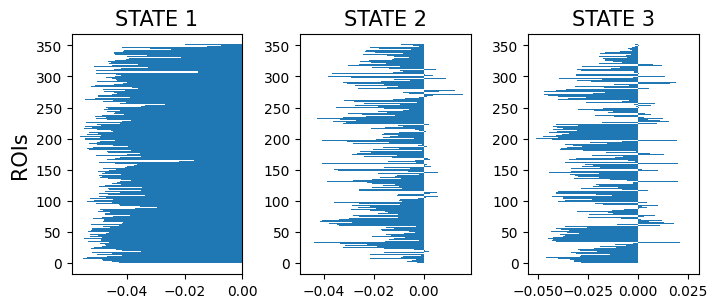

In [20]:
# PLot CENTROIDS
fig, axs = plt.subplots(1,num_states,figsize=(7,3))
fig.tight_layout()
for i in range(num_states):
    axs[i].set_title('STATE {}' .format(i+1), fontsize=15)
    axs[i].barh(range(states[i].shape[0]), states[i], height=1);
#              tick_label=nodes_labels)
    axs[0].set_ylabel('ROIs', fontsize=15)

## 3 - Back to PL matrices and compute some graph metrics 

In [65]:
group_labels[0]

array([1.])

In [69]:
# time points belonging to each state [state x time points]
states_index = []
for s in np.unique(state_labels):
    states_index.append(np.where(state_labels==s))

# Divide states indexes by group
groups_index = []
for g in np.unique(group_labels):
    groups_index.append(np.where(group_labels==g)[0])

In [70]:
# states_index[2][0].shape
groups_index

[array([ 9310,  9311,  9312, ..., 17637, 17638, 17639]),
 array([   0,    1,    2, ..., 9307, 9308, 9309]),
 array([ 490,  491,  492, ..., 5877, 5878, 5879])]

In [71]:
states_index_groups = [] # [state 1, state2, state 3]
for s in states_index:
    groupz = {0:[], 1:[], 2:[]}
    for t in s[0]:
        groupz[group_labels[t][0]].append(t)
    states_index_groups.append(groupz)

In [28]:
############################
### PERCOLATION ANALYSIS ###
############################

# Guardo come variano le metriche (tipo average shortest path e number of connected components) al variare della
# threshold che applico per binarizzare il grafo.
# Dovrei anche guardare cosa succede se vario la threshold che uso per le singole matrice di phase locking, ma lo
# facciamo un'altra volta

# I want to find the proper threshold for the three states
states_index = []
for s in np.unique(state_labels):
    states_index.append(np.where(state_labels==s))

states_mets = []
states_mets_2 = []
for s in range(3): # Loop over states
    print('STATE ', s)
    mets = []
    mets_2 = []
    x = np.arange(0.2,0.6,0.02)
#     x = [0.2, 0.6]
    for thresh_2 in x:
        if thresh_2%0.2==0:
            print(thresh_2)
        thresh = 0.99
        n_pick = 50
        n_samp = 50

        met = []
        met_2 = []
        for t in range(n_pick):
            # Pick a random s-ample of phase locking matrix
            idxs = random.choices(states_index[s][0], k=n_samp)
            mat = np.empty((0,t_iFC_noles.shape[-2],t_iFC_noles.shape[-1]))
            for j in idxs:
#                 print('pino', j)
                np.fill_diagonal(t_iFC_noles[j], 0) # Remove ones on the diagonal
                m = t_iFC_noles[j]
                m = np.abs(m)
                m[np.where(m<thresh)] = 0
                mat = np.concatenate((mat, np.expand_dims(m, axis=0)))
            meanchia = mat.mean(axis=0)
            # Devo thresholdare pure la matrice media
            meanchia[np.where(meanchia<thresh_2)] = 0

            # MEANCHIA DEVO TRESHOLDARLA PRIMA DI CREARE IL GRAFO
            G = nx.from_numpy_array(meanchia)
            # Which metrics I want to look at
            met.append(graph_metrics('average_shortest_path', G))
            met_2.append(graph_metrics('number_connected_components', G))
        mets.append(met)
        mets_2.append(met_2)
    states_mets.append(mets)
    states_mets_2.append(mets_2)

STATE  0
0.2
STATE  1
0.2
STATE  2
0.2


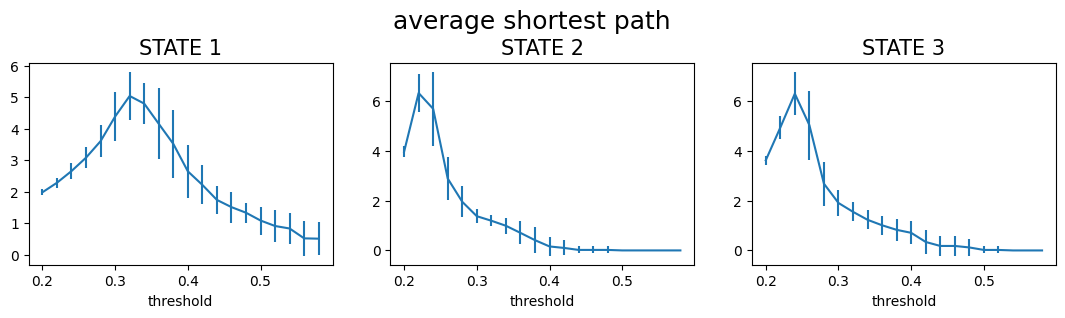

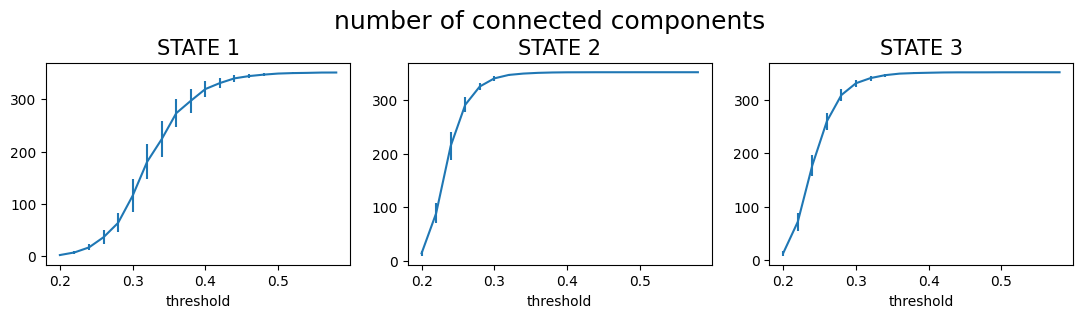

In [44]:
# shortest path
y_states = []
y_err_states = []
for mets in states_mets:
    y = []
    y_err = []
    for m in mets:
#         y.append(np.median(m))
        y.append(np.mean(m))

        y_err.append(np.std(m))
    y_states.append(y)
    y_err_states.append(y_err)

states_thresh = [] # For each state store threshold computed with percolation analysis
fig, axs = plt.subplots(1,len(y_states), figsize=(11,3))
fig.suptitle('average shortest path', fontsize=18)
fig.tight_layout()
for s,met in enumerate(y_states):
    axs[s].set_title('STATE {}'.format(s+1), fontsize=15)
    axs[s].errorbar(x, met, yerr=y_err_states[s])
    axs[s].set_xlabel('threshold')
    states_thresh.append(x[np.argmax(y_states[s])])
    
# number connected components
y_states_2 = []
y_err_states_2 = []
for mets in states_mets_2:
    y = []
    y_err = []
    for m in mets:
#         y.append(np.median(m))
        y.append(np.mean(m))

        y_err.append(np.std(m))
    y_states_2.append(y)
    y_err_states_2.append(y_err)

fig, axs = plt.subplots(1,len(y_states_2), figsize=(11,3))
fig.suptitle('number of connected components', fontsize=18)
fig.tight_layout()
for s,met in enumerate(y_states_2):
    axs[s].set_title('STATE {}'.format(s+1), fontsize=15)
    axs[s].errorbar(x, met, yerr=y_err_states_2[s])
    axs[s].set_xlabel('threshold')
#     states_thresh.append(x[np.argmax(y_states_2[s])])

In [ ]:
# # Dividing by groups
# metric_states = [] # metrics for each state
# for s in range(3): # Loop over states
#     metrics = [] # metrics for each state
#     x = np.arange(0.2,0.6,0.025)
#     # I have to evaluate the metrics for the three groups
#     metrics = [] # metrics for each state
#     for g_idx in range(3):
#         mets = [] # metrics for each group
#         for thresh_2 in x:
#             print(thresh_2)
#             thresh = 0.99
#             n_pick = 50
#             n_samp = 50

#             met = [] # met contain each pick
#             for t in range(n_pick):
#                 # Pick a random s-ample of phase locking matrix
#                 idxs = random.choices(states_index_groups[s][g_idx], k=n_samp)
#                 mat = np.empty((0,t_iFC_noles.shape[-2],t_iFC_noles.shape[-1]))
#                 for j in idxs:
#                     np.fill_diagonal(t_iFC_noles[j], 0) # Remove ones on the diagonal
#                     m = t_iFC_noles[j]
#                     m = np.abs(m)
#                     m[np.where(m<thresh)] = 0
#                     mat = np.concatenate((mat, np.expand_dims(m, axis=0)))
#                 meanchia = mat.mean(axis=0)
#                 # Devo thresholdare pure la matrice media
#                 meanchia[np.where(meanchia<thresh_2)] = 0

#                 # MEANCHIA DEVO TRESHOLDARLA PRIMA DI CREARE IL GRAFO
#                 G = nx.from_numpy_matrix(meanchia)
#                 # Which metrics I want to look at
#                 met.append(graph_metrics('average_shortest_path', G))
#             mets.append(met) # mets contain each thresh val
#         metrics.append(mets) # metrics contain each group
#     metric_states.append(metrics) # metrics state contain each state
    
# # threhshold dividing sample in both states and groups
# for s,states_mets in enumerate(metric_states):
#     y_states = []
#     y_err_states = []
#     for mets in states_mets:
#         y = []
#         y_err = []
#         for m in mets:
#     #         y.append(np.median(m))
#             y.append(np.mean(m))

#             y_err.append(np.std(m))
#         y_states.append(y)
#         y_err_states.append(y_err)

#     states_thresh = [] # For each state store threshold computed with percolation analysis
#     fig, axs = plt.subplots(1,len(y_states), figsize=(11,3))
#     for g,met in enumerate(y_states):
#         axs[g].set_title('STATE {} - average shrotest path'.format(s+1), fontsize=8)
#         axs[g].errorbar(x, met, yerr=y_err_states[g])
#         axs[g].set_xlabel('threshold')
# #         states_thresh.append(x[np.argmax(y_states[s])])
#     # axs[1].set_title('number of connected components')
#     # axs[1].errorbar(x, y_2, yerr=y_err_2)
#     # axs[1].set_xlabel('threshold')

In [23]:
states_thresh = [0.31999999999999995, 0.22, 0.24]

In [ ]:
# GLOBAL METRICS

today = date.today()
DATE = today.strftime("%d%m%Y")
# checking if the directory exists or not
if not os.path.exists('output/GraphAnal/'+DATE):
      
    # if the demo_folder directory is not present 
    # then create it.
    os.makedirs('output/GraphAnal/'+DATE)

# Once I compute the optimal threshold I can compare metrics between groups
metriche = ['average_shortest_path','number_connected_components','size_giant_component',
            'fraction_of_edges','average_degree',
            'average_local_efficiency', 'global_efficiency']
eps = 0.1

for metrica in metriche:
    metrics = [] # metrics for each state
    for s in range(3): # Loop over states
        thresh_2 = states_thresh[s]
        print(metrica)
        thresh = 0.99
        n_pick = 50
        n_samp = 50
        mets = [] # metrics for each group
        # I have to evaluate the metrics for the three groups
        for g_idx in range(3):
            met = []
            for t in range(n_pick):
                # Pick a random s-ample of phase locking matrix
                idxs = random.choices(states_index_groups[s][g_idx], k=n_samp)
                mat = np.empty((0,t_iFC_noles.shape[-2],t_iFC_noles.shape[-1]))
                for j in idxs:
                    np.fill_diagonal(t_iFC_noles[j], 0) # Remove ones on the diagonal
                    m = t_iFC_noles[j]
                    m = np.abs(m)
                    m[np.where(m<thresh)] = 0
                    mat = np.concatenate((mat, np.expand_dims(m, axis=0)))
                meanchia = mat.mean(axis=0)
                # Devo thresholdare pure la matrice media
                meanchia[np.where(meanchia<thresh_2)] = 0

                # MEANCHIA DEVO TRESHOLDARLA PRIMA DI CREARE IL GRAFO
                G = nx.from_numpy_array(meanchia)
                # Which metrics I want to look at
                met.append(graph_metrics(metrica, G))
            mets.append(met)
        metrics.append(mets)

    fig = plt.figure(figsize=(6,4))
    plt.title(metrica)
    with open('output/GraphAnal/'+DATE+'/'+metrica+'_npick'+str(n_pick)+'_nsamp'+str(n_samp)+'_'+DATE+'_ttest.txt', 'w') as f:
        for s in range(num_states):
        #     plt.ylim(0,1)
            bp = plt.boxplot([metrics[s][0], metrics[s][1], metrics[s][2]], positions = [s-eps, s, s+eps],
                             patch_artist=True,
                             labels=['','State'+str(s+1),''], showfliers=False)
            bp['boxes'][0].set_facecolor('blue')
            bp['boxes'][1].set_facecolor('green')
            bp['boxes'][2].set_facecolor('red')

            # t-tests 
            print('STATE ', s+1)
            test1 = ttest_ind(metrics[s][0], metrics[s][1])
            print(test1)
            test2 = ttest_ind(metrics[s][0], metrics[s][2])
            print(test2)
            test3 = ttest_ind(metrics[s][1], metrics[s][2])
            print(test3)
            print('\n')

            # WRIte ttest results
            f.write('STATE {}'.format(str(s+1)))
            f.write('\n')
            f.write(str(test1))
            f.write(' CvsB')
            f.write('\n')
            f.write(str(test2))
            f.write(' CvsNB')
            f.write('\n')
            f.write(str(test3))
            f.write(' BvsNB')
            f.write('\n')


    plt.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2]], ['C', 'B', 'NB'], loc='upper left')
    plt.savefig('output/GraphAnal/'+DATE+'/'+metrica+'_npick'+str(n_pick)+'_nsamp'+str(n_samp)+'_'+DATE+'.png')
    
    
    
#     p_1 = ttest_ind(C_met, B_met)[1]
#     axs.set_title(metrica+' - p CvsB = {} CvsNB = {} BvsNB = {}'.format(round(p_1,4), round(p_2,4), round(p_3,4)), fontsize=11)
#     axs.boxplot([C_met, B_met, NB_met], labels=['C','B','NB'], showfliers=False);

average_shortest_path
average_shortest_path
average_shortest_path
STATE  1
Ttest_indResult(statistic=-0.7582031432617261, pvalue=0.4501488918727037)
Ttest_indResult(statistic=-4.787509731483565, pvalue=5.984739127701143e-06)
Ttest_indResult(statistic=-4.671300593927584, pvalue=9.534183832871737e-06)


STATE  2
Ttest_indResult(statistic=2.648690027550419, pvalue=0.009419332058439634)
Ttest_indResult(statistic=8.752072084258806, pvalue=6.148890848530662e-14)
Ttest_indResult(statistic=6.236092378328323, pvalue=1.1381332079237295e-08)


STATE  3
Ttest_indResult(statistic=-2.1896656610786214, pvalue=0.030921578369209855)
Ttest_indResult(statistic=3.3709333325746607, pvalue=0.0010730566274387932)
Ttest_indResult(statistic=6.721283953766795, pvalue=1.2001124229624255e-09)


number_connected_components
number_connected_components
number_connected_components
STATE  1
Ttest_indResult(statistic=-3.3568090752715194, pvalue=0.0011233774344290653)
Ttest_indResult(statistic=-2.4079778594509214, pvalu

STATE  1
STATE  2
STATE  3


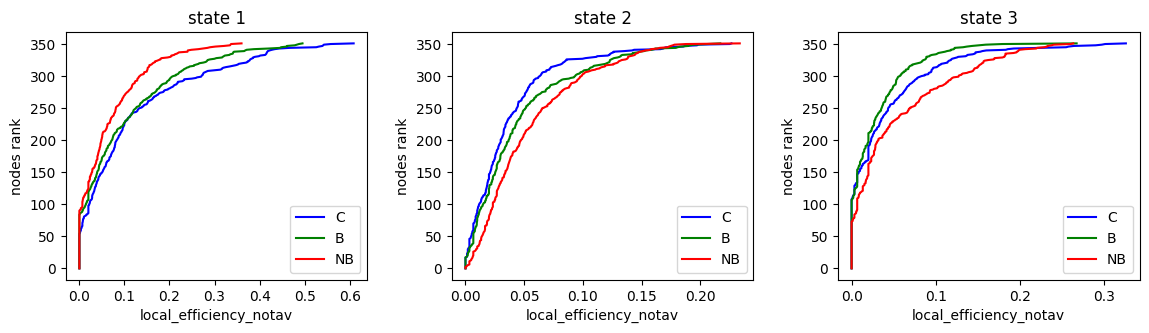

In [102]:
# PARDALOS PLOT - rank each node with respect to local efficiency

today = date.today()
DATE = today.strftime("%d%m%Y")
# checking if the directory exists or not
if not os.path.exists('output/GraphAnal/'+DATE): 
    # if the demo_folder directory is not present 
    # then create it.
    os.makedirs('output/GraphAnal/'+DATE)

metrica='local_efficiency_notav'
# metrica='betweeness_centrality'
# metrica='eigenvector_centrality'

eps = 0.1

metrics = [] # metrics for each state- 
for s in range(3): # Loop over states
    print('STATE ', s+1)
    thresh_2 = states_thresh[s]
    thresh = 0.99
    n_pick = 50
    n_samp = 50
    mets = [] # metrics for each group
    # I have to evaluate the metrics for the three groups
    for g_idx in range(3):
        met = []
        met = np.empty((0,352))
        for t in range(n_pick):
            # Pick a random s-ample of phase locking matrix
            idxs = random.choices(states_index_groups[s][g_idx], k=n_samp)
            mat = np.empty((0,t_iFC_noles.shape[-2],t_iFC_noles.shape[-1]))
            for j in idxs:
                np.fill_diagonal(t_iFC_noles[j], 0) # Remove ones on the diagonal
                m = t_iFC_noles[j]
                m = np.abs(m)
                m[np.where(m<thresh)] = 0
                mat = np.concatenate((mat, np.expand_dims(m, axis=0)))
            meanchia = mat.mean(axis=0)
            # Devo thresholdare pure la matrice media
            meanchia[np.where(meanchia<thresh_2)] = 0

            # MEANCHIA DEVO TRESHOLDARLA PRIMA DI CREARE IL GRAFO
            G = nx.from_numpy_array(meanchia)
            # Which metrics I want to look at
            mmm = graph_metrics(metrica, G)
            mmm = np.expand_dims(np.asarray(mmm), axis=0)
            met = np.concatenate((met, mmm))
        mets.append(met) # groups
    metrics.append(mets) # states

fig,axs = plt.subplots(1,3,figsize=(12,3.6))
labels = ['C', 'B', 'NB']
colors = ['blue','green','red']
fig.tight_layout(pad=3.0)
for s in range(num_states):
    axs[s].set_title('state {}'.format(s+1))
    for g in range(3):
        m = np.mean(metrics[s][g], axis=0)
        m = np.sort(m)
        axs[s].plot(m,range(m.shape[0]), label=labels[g], color=colors[g])
        axs[s].set_xlabel(metrica)
        axs[s].set_ylabel('nodes rank')

    axs[s].legend(loc='lower right')


# plt.savefig('output/GraphAnal/'+DATE+'/Pardalos_'+metrica+'_npick'+str(n_pick)+'_nsamp'+str(n_samp)+'_'+DATE+'.png')

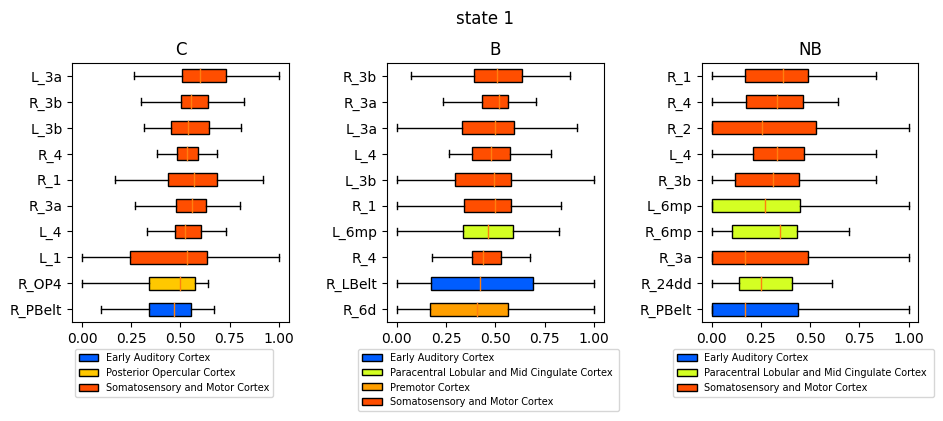

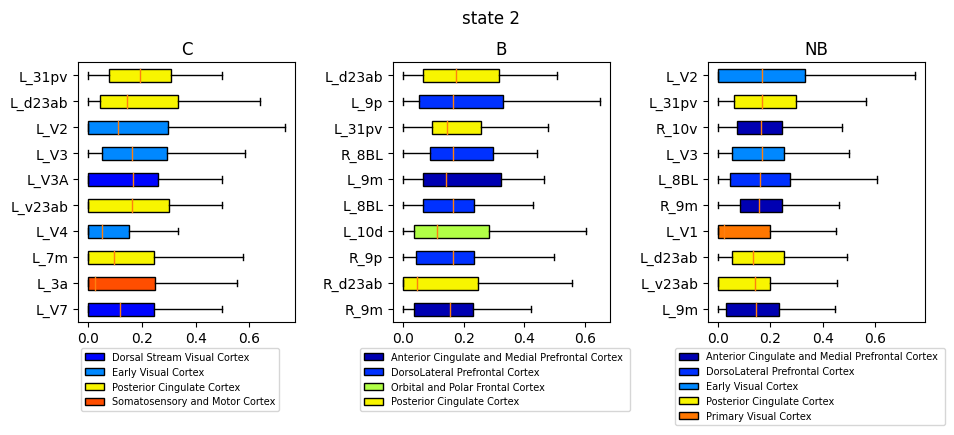

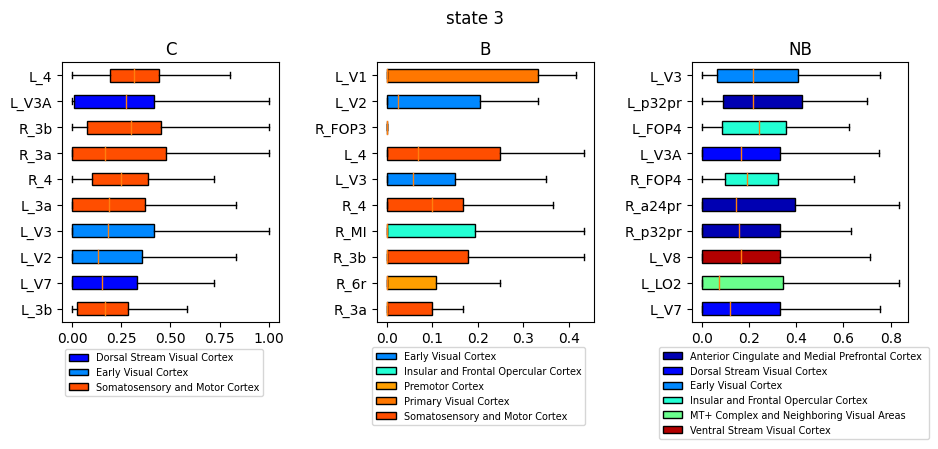

In [103]:
today = date.today()
DATE = today.strftime("%d%m%Y")
# checking if the directory exists or not
if not os.path.exists('output/GraphAnal/'+DATE): 
    # if the demo_folder directory is not present 
    # then create it.
    os.makedirs('output/GraphAnal/'+DATE)

n = 10
# I want one color for macro area
## START COLOR STUFF ##

# Divide areas for macro areas
mas = np.unique(atlas_labels['macro_area'].values)
mas_idx = {}
mas_dic = {}
new_mas = ['subcortical'] # put inside a unique macro area all the subcortical regions
subcort = ['Superior Colliculus','Thalamus', 'Tian_Accumbens',
           'Tian_Amygdala', 'Tian_Caudate', 'Tian_Pallidus', 'Tian_Putamen',
           'Tian_Thalamus', 'Substantia_Nigra']
mas_dic[0] = []
i = 1
for ma in mas:
    # put inside a unique macro area all the subcortical regions
    if ma not in subcort:
        mas_idx[ma] = i
        mas_dic[i] = []
        i += 1
        new_mas.append(ma)
    else:
        mas_idx[ma] = 0
        
for ii,i in enumerate(no_les_idx):
    mas_dic[mas_idx[atlas_labels.iloc[i]['macro_area']]].append(ii)

new_mas_l = [m for m in new_mas]

mas_dic_count = [len(mas_dic[k]) for k in mas_dic.keys()]
mas_dic_count_new = [0]
prev = 0
for c in mas_dic_count:
    prev += c/np.sum(mas_dic_count)
    mas_dic_count_new.append(prev)
mas_dic_count = mas_dic_count_new

cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
       'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(0, len(new_mas_l)-1, len(new_mas_l))
norm = mpl.colors.BoundaryNorm(mas_dic_count, cmap.N)

states_mas_color = []
mas_color = []
for k in mas_dic.keys():
    i = 0
    mas_color.append(cmap(k/len(new_mas_l)))
    for _ in mas_dic[k]:
        states_mas_color.append(cmap(k/len(new_mas_l)))
        i += 1
## END COLOR STUFF ##      
        
tit = ['C','B','NB']
# c = 'red'
for i in range(3):
    fig,axs = plt.subplots(1,3, figsize=(10,4))
    fig.tight_layout(pad=4.0)
    for j in range(3):
        
#         print(np.argsort(np.mean(metrics[i][j],axis=0))[::-1][:10])
#         axs[(i*3)+j].boxplot(np.transpose(metrics[i][j][:,np.argsort(np.mean(metrics[i][j],axis=0))[::-1][:n]]),
#                     vert=False, showfliers=False, positions=[k for k in range(n)])
        fig.suptitle('state {}'.format(i+1))
        lll = no_les_labels[np.argsort(np.mean(metrics[i][j],axis=0))[::-1][:n]] # areas name
        ll = []
        c = []
        for l in no_les_labels[np.argsort(np.mean(metrics[i][j],axis=0))[::-1][:n]]:
            if l not in subcort:
                m_a = atlas_labels[atlas_labels['area']==l]['macro_area'].values[0]
            else:
                m_a = 'subcortical'
            ll.append(m_a)
            c.append(mas_color[new_mas.index(m_a)])
        bp = axs[j].boxplot(metrics[i][j][:,np.argsort(np.mean(metrics[i][j],axis=0))[::-1][:n]],
                          vert=False, showfliers=False, positions=[k for k in range(n)][::-1],
                          labels=lll, patch_artist=True)
        for f,patch in enumerate(bp['boxes']):
                patch.set(facecolor=c[f]) 
        axs[j].set_title(tit[j])
        uu = np.unique(ll)
        arguu = [ll.index(u) for u in uu]
        axs[j].legend([bp['boxes'][u] for u in arguu], uu, loc='lower center',
                      bbox_to_anchor=(0.22, -0.25-(len(uu)-2)*0.055, 0.5, 0.2), fontsize=7)
#         axs[j].set_xticks([])
    plt.savefig('output/GraphAnal/'+DATE+'/'+metrica+'Rank_state'+str(i+1)+'_npick'+str(n_pick)+'_nsamp'+str(n_samp)+'_'+DATE+'.png',
                dpi=300)

In [56]:
for s in range(num_states):
    for g in range(3):
        m = np.mean(metrics[s][g], axis=0)
        m = np.sort(m)
        print(np.mean(m))

0.10830110946353516
0.0872397086029601
0.06190354658011137
0.03407958932301465
0.04607614148950676
0.06270732346454021
0.036287972000126185
0.028211769442354727
0.05138601664429332


In [84]:
# Divides the nodes in macro areas
# Divide areas for macro areas
mas = np.unique(atlas_labels['macro_area'].values)
mas_idx = {}
mas_dic = {}
new_mas = ['subcortical'] # put inside a unique macro area all the subcortical regions
subcort = ['Superior Colliculus','Thalamus', 'Tian_Accumbens',
           'Tian_Amygdala', 'Tian_Caudate', 'Tian_Pallidus', 'Tian_Putamen',
           'Tian_Thalamus', 'Substantia_Nigra']
mas_dic[0] = []
i = 1
for ma in mas:
    # put inside a unique macro area all the subcortical regions
    if ma not in subcort:
        mas_idx[ma] = i
        mas_dic[i] = []
        i += 1
        new_mas.append(ma)
    else:
        mas_idx[ma] = 0
        
for ii,i in enumerate(no_les_idx):
    mas_dic[mas_idx[atlas_labels.iloc[i]['macro_area']]].append(ii)
    
mas_list = []
for k in mas_dic.keys():
    mas_list.append(mas_dic[k])

STATE  1
STATE  2
STATE  3
STATE  1
Ttest_indResult(statistic=-1.8858020461713205, pvalue=0.06228314439280287)
Ttest_indResult(statistic=-3.1387738505751575, pvalue=0.002241836812951831)
Ttest_indResult(statistic=-1.6858741855445523, pvalue=0.0950015149296858)


STATE  2
Ttest_indResult(statistic=0.49904588870810124, pvalue=0.6188654695733777)
Ttest_indResult(statistic=2.8286932170786083, pvalue=0.005668665084590452)
Ttest_indResult(statistic=2.183050279641962, pvalue=0.031419969805981655)


STATE  3
Ttest_indResult(statistic=3.3766336606871414, pvalue=0.001053353906741338)
Ttest_indResult(statistic=9.524761548089613, pvalue=1.3019036488690547e-15)
Ttest_indResult(statistic=5.4739023214160465, pvalue=3.3891517142934123e-07)




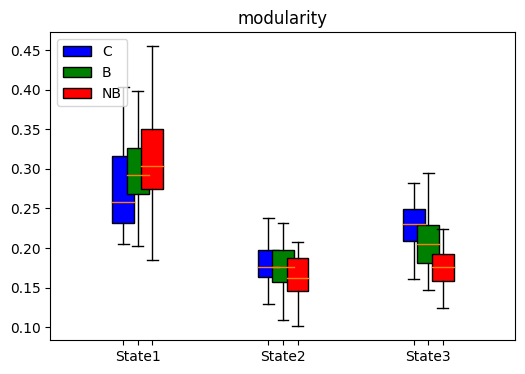

In [59]:
# EFFICIENCY, INTEGRATION and SEGREGATION
# Modularity measures segregation



# PARDALOS PLOT - rank each node with respect to local efficiency

# today = date.today()
# DATE = today.strftime("%d%m%Y")
# # checking if the directory exists or not
# if not os.path.exists('output/'+DATE): 
#     # if the demo_folder directory is not present 
#     # then create it.
#     os.makedirs('output/'+DATE)

eps = 0.1

metrics = [] # metrics for each state
for s in range(3): # Loop over states
    print('STATE ', s+1)
    thresh_2 = states_thresh[s]
    thresh = 0.99
    n_pick = 50
    n_samp = 50
    mets = [] # metrics for each group
    # I have to evaluate the metrics for the three groups
    for g_idx in range(3):
        met = []
        for t in range(n_pick):
            # Pick a random s-ample of phase locking matrix
            idxs = random.choices(states_index_groups[s][g_idx], k=n_samp)
            mat = np.empty((0,t_iFC_noles.shape[-2],t_iFC_noles.shape[-1]))
            for j in idxs:
                np.fill_diagonal(t_iFC_noles[j], 0) # Remove ones on the diagonal
                m = t_iFC_noles[j]
                m = np.abs(m)
                m[np.where(m<thresh)] = 0
                mat = np.concatenate((mat, np.expand_dims(m, axis=0)))
            meanchia = mat.mean(axis=0)
            # Devo thresholdare pure la matrice media
            meanchia[np.where(meanchia<thresh_2)] = 0

            # MEANCHIA DEVO TRESHOLDARLA PRIMA DI CREARE IL GRAFO
            G = nx.from_numpy_array(meanchia)
            # Which metrics I want to look at
            met.append(nx.community.modularity(G, mas_list))
        mets.append(met) # groups
    metrics.append(mets) # states

fig = plt.figure(figsize=(6,4))
plt.title('modularity')
with open('output/GraphAnal/'+DATE+'/modularity_npick'+str(n_pick)+'_nsamp'+str(n_samp)+'_'+DATE+'_ttest.txt', 'w') as f:
    for s in range(num_states):
    #     plt.ylim(0,1)
        bp = plt.boxplot([metrics[s][0], metrics[s][1], metrics[s][2]], positions = [s-eps, s, s+eps],
                         patch_artist=True,
                         labels=['','State'+str(s+1),''], showfliers=False)
        bp['boxes'][0].set_facecolor('blue')
        bp['boxes'][1].set_facecolor('green')
        bp['boxes'][2].set_facecolor('red')

        # t-tests 
        print('STATE ', s+1)
        test1 = ttest_ind(metrics[s][0], metrics[s][1])
        print(test1)
        test2 = ttest_ind(metrics[s][0], metrics[s][2])
        print(test2)
        test3 = ttest_ind(metrics[s][1], metrics[s][2])
        print(test3)
        print('\n')

        # WRIte ttest results
        f.write('STATE {}'.format(str(s+1)))
        f.write('\n')
        f.write(str(test1))
        f.write(' CvsB')
        f.write('\n')
        f.write(str(test2))
        f.write(' CvsNB')
        f.write('\n')
        f.write(str(test3))
        f.write(' BvsNB')
        f.write('\n')


plt.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2]], ['C', 'B', 'NB'], loc='upper left')
plt.savefig('output/GraphAnal/'+DATE+'/modularity_npick'+str(n_pick)+'_nsamp'+str(n_samp)+'_'+DATE+'.png')

## 4 - 